In [2]:
# 🔹 Importation des bibliothèques nécessaires
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

📥 Chargement des données...
✅ Données chargées : 8011296 lignes, 11 colonnes.
🔄 Normalisation des données...
✅ Normalisation terminée.
🔄 Réduction de dimension avec l'ACP...
✅ ACP terminée.
🔍 Filtrage des outliers...
✅ Filtrage terminé : 7694048 lignes restantes.
📊 Recherche du meilleur nombre de clusters...
➡️ Test avec k=2
➡️ Test avec k=3
➡️ Test avec k=4
➡️ Test avec k=5
➡️ Test avec k=6
➡️ Test avec k=7
➡️ Test avec k=8
➡️ Test avec k=9


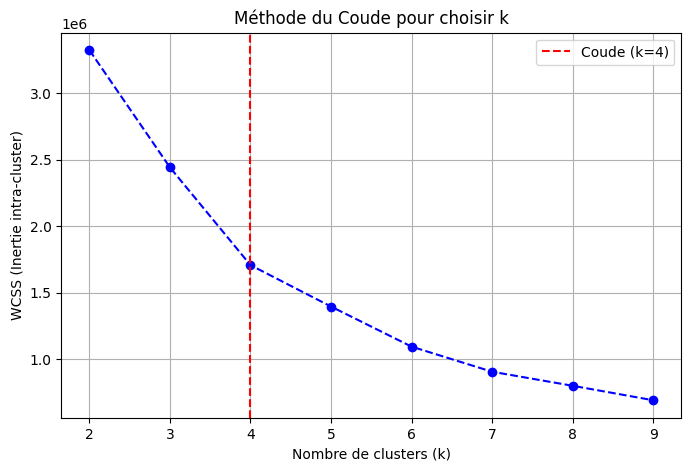

✅ Méthode du coude terminée.
🚀 Début de l'application de K-Means avec k=4 clusters...
➡️ Entraînement du modèle K-Means...
✅ Entraînement terminé.
➡️ Calcul du score de silhouette...
✅ Score de silhouette : 0.4807
➡️ Visualisation des clusters...


c:\Users\Pierre\Desktop\Projet Amazing\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


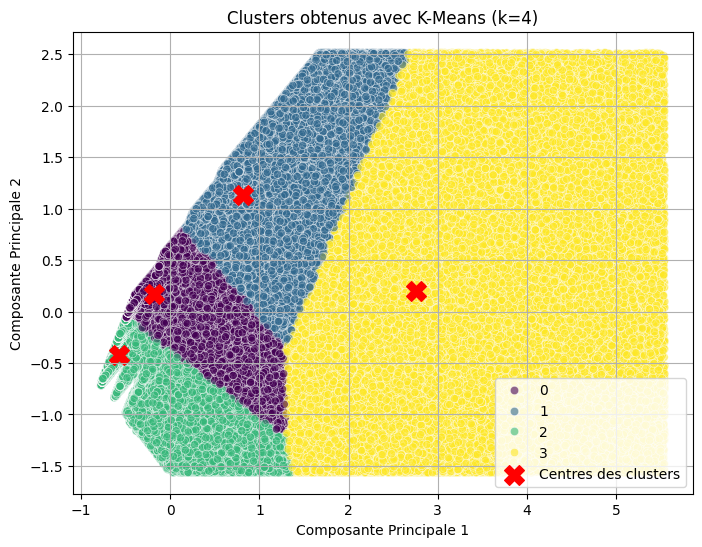

✅ Visualisation terminée.
💾 Sauvegarde du modèle et des résultats...
✅ Modèle et résultats sauvegardés.


In [4]:
# 🔹 Chargement des données
print("📥 Chargement des données...")
df = pd.read_parquet("../data/output/user_features_v2.parquet")
print(f"✅ Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes.")

# 🔹 Normalisation des données
print("🔄 Normalisation des données...")
scaler = StandardScaler()
features = ["total_events", "total_views", "total_carts", "total_purchases", 
            "total_spent", "unique_categories", "days_since_last_event"]
df_scaled = scaler.fit_transform(df[features])
print("✅ Normalisation terminée.")

# 🔹 Réduction de dimension avec l'ACP
print("🔄 Réduction de dimension avec l'ACP...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
df_pca["user_id"] = df["user_id"]
print("✅ ACP terminée.")

# 🔹 Gestion des outliers
print("🔍 Filtrage des outliers...")
q_low_pc1 = df_pca["PC1"].quantile(0.01)
q_high_pc1 = df_pca["PC1"].quantile(0.99)
df_pca = df_pca[(df_pca["PC1"] >= q_low_pc1) & (df_pca["PC1"] <= q_high_pc1)]

q_low_pc2 = df_pca["PC2"].quantile(0.01)
q_high_pc2 = df_pca["PC2"].quantile(0.99)
df_pca = df_pca[(df_pca["PC2"] >= q_low_pc2) & (df_pca["PC2"] <= q_high_pc2)]
print(f"✅ Filtrage terminé : {df_pca.shape[0]} lignes restantes.")

# 🔹 Détermination du nombre optimal de clusters (Méthode du coude)
print("📊 Recherche du meilleur nombre de clusters...")
wcss = []  # Inertie intra-cluster
range_k = range(2, 10)  # Plage de recherche pour k

for k in range_k:
    print(f"➡️ Test avec k={k}")
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, max_iter=100)
    kmeans.fit(df_pca[["PC1", "PC2"]])
    wcss.append(kmeans.inertia_)

# 📊 Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(range_k, wcss, marker="o", linestyle="--", color="b")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("WCSS (Inertie intra-cluster)")
plt.title("Méthode du Coude pour choisir k")
plt.axvline(x=4, color="red", linestyle="--", label="Coude (k=4)")  # Annotation du coude
plt.legend()
plt.grid()
plt.show()
print("✅ Méthode du coude terminée.")

# 🎯 Application de K-Means avec le nombre optimal de clusters
optimal_k = 4  # Choix basé sur la courbe du coude
print(f"🚀 Début de l'application de K-Means avec k={optimal_k} clusters...")
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1000, max_iter=100)

print("➡️ Entraînement du modèle K-Means...")
df_pca["Cluster"] = kmeans.fit_predict(df_pca[["PC1", "PC2"]])
print("✅ Entraînement terminé.")

# 🔹 Calcul du score de silhouette
print("➡️ Calcul du score de silhouette...")
sample_size = min(50000, len(df_pca))  # Limite à 50 000 échantillons pour accélérer
df_sample = df_pca.sample(n=sample_size, random_state=42)
silhouette_values = silhouette_samples(df_sample[["PC1", "PC2"]], df_sample["Cluster"])
sil_score = np.mean(silhouette_values)
print(f"✅ Score de silhouette : {sil_score:.4f}")

# 📊 Visualisation des clusters
print("➡️ Visualisation des clusters...")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["Cluster"], palette="viridis", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="red", marker="X", s=200, label="Centres des clusters")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title(f"Clusters obtenus avec K-Means (k={optimal_k})")
plt.legend()
plt.grid(True)
plt.show()
print("✅ Visualisation terminée.")

# 🔹 Sauvegarde du modèle et des résultats
print("💾 Sauvegarde du modèle et des résultats...")
joblib.dump(kmeans, "../data/output/kmeans_model-test.pkl")
joblib.dump(scaler, "../data/output/scaler-test.pkl")
joblib.dump(pca, "../data/output/pca_model-test.pkl")
df_pca.to_parquet("../data/output/user_clusters-test.parquet", index=False)
print("✅ Modèle et résultats sauvegardés.")

➡️ Analyse des poids des variables dans les composantes principales...


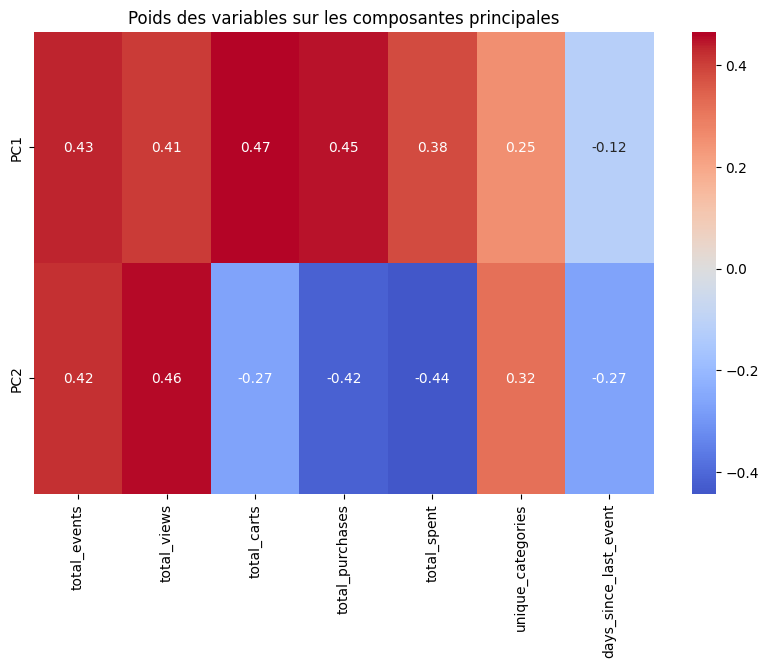

✅ Analyse des poids terminée.
➡️ Variance expliquée par les composantes principales...


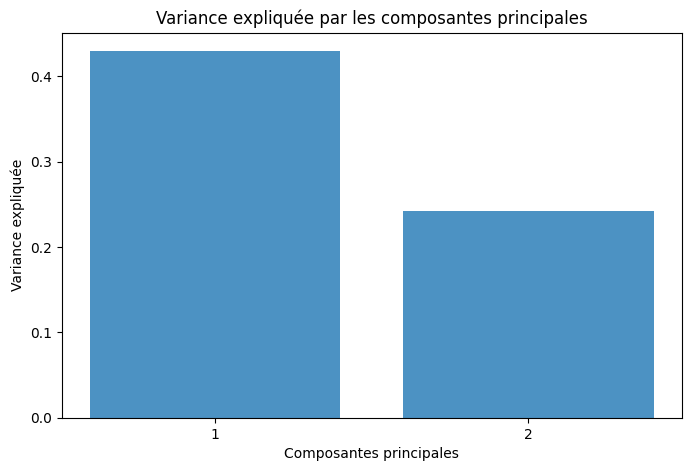

✅ Variance expliquée visualisée.
➡️ Contribution des variables aux composantes principales...


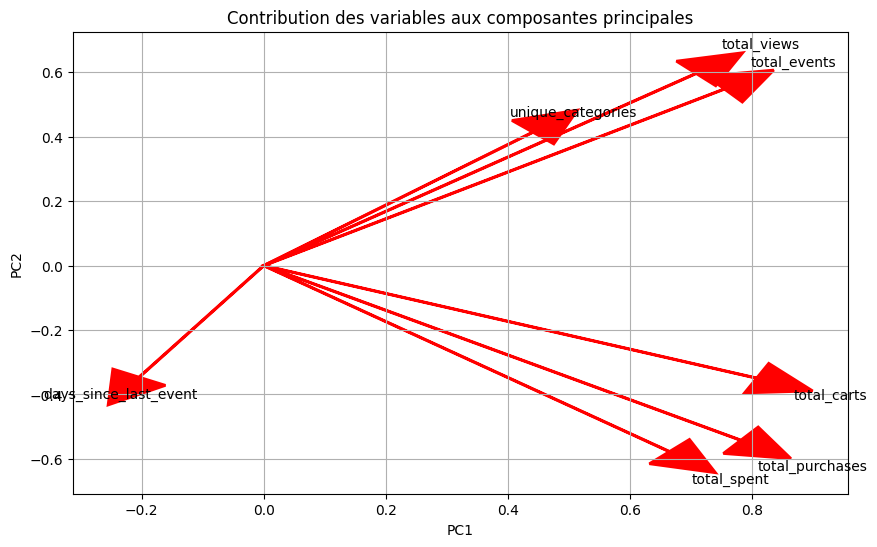

✅ Contribution des variables visualisée.


In [4]:
#  Analyse des poids des variables dans les composantes principales
print("➡️ Analyse des poids des variables dans les composantes principales...")
pca_components = pd.DataFrame(pca.components_, columns=features, index=["PC1", "PC2"])

plt.figure(figsize=(10, 6))
sns.heatmap(pca_components, annot=True, cmap="coolwarm", center=0)
plt.title("Poids des variables sur les composantes principales")
plt.show()
print("✅ Analyse des poids terminée.")

#  Variance expliquée par les composantes principales
print("➡️ Variance expliquée par les composantes principales...")
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align="center")
plt.xticks(range(1, len(explained_variance) + 1))
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliquée")
plt.title("Variance expliquée par les composantes principales")
plt.show()
print("✅ Variance expliquée visualisée.")

#  Contribution des variables aux composantes principales
print("➡️ Contribution des variables aux composantes principales...")
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(10, 6))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.1, head_length=0.1, linewidth=2, color="red")
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature, color="black", ha="center", va="center")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Contribution des variables aux composantes principales")
plt.grid(True)
plt.show()
print("✅ Contribution des variables visualisée.")

In [5]:
print("➡️ Comptage des éléments par cluster...")
cluster_counts = df_pca["Cluster"].value_counts().sort_index()  # Tri par index pour une meilleure lisibilité
print(cluster_counts)
print("✅ Comptage terminé.")

➡️ Comptage des éléments par cluster...
Cluster
0    2792821
1     910680
2    3754999
3     235548
Name: count, dtype: int64
✅ Comptage terminé.


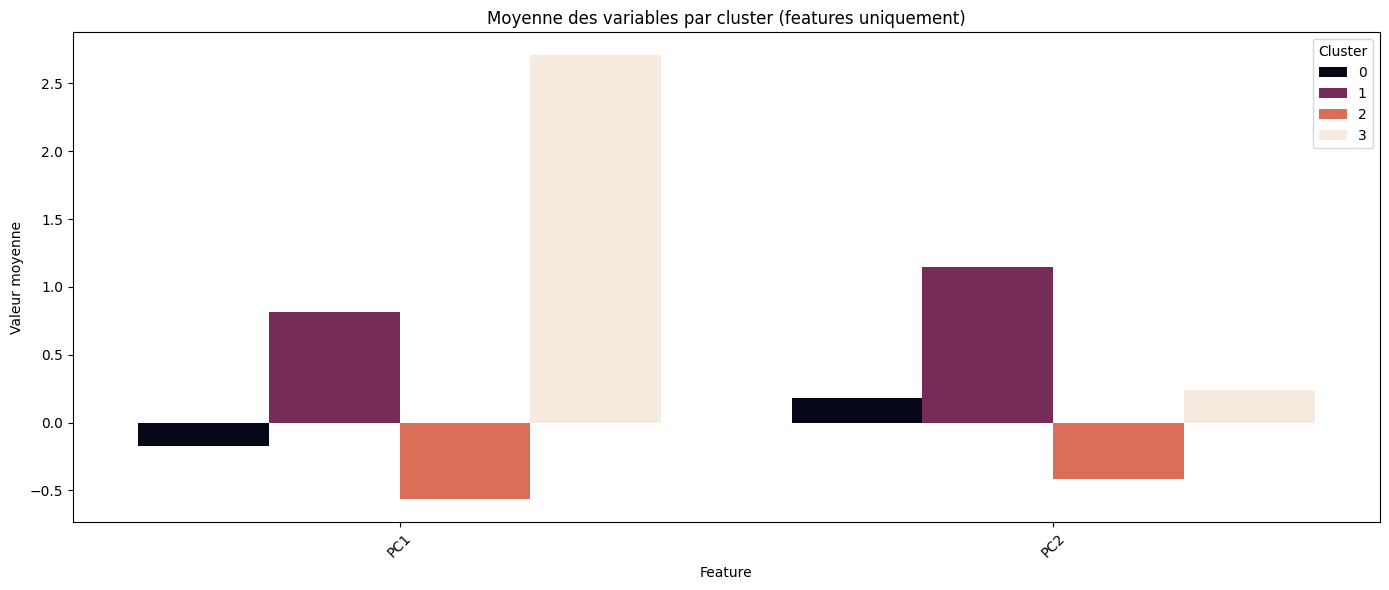

In [10]:
# Étape 1 : Supprimer les colonnes non pertinentes (comme les identifiants)
features_cols = [col for col in df_pca.columns if col not in ['user_id', 'Cluster']]
df_features = df_pca[features_cols]

# Étape 2 : Calculer la moyenne des features par cluster
cluster_means = df_pca.groupby('Cluster')[features_cols].mean()

# Étape 3 : Préparer les données pour un barplot groupé
cluster_means_reset = cluster_means.reset_index().melt(id_vars='Cluster', 
                                                       var_name='Feature', 
                                                       value_name='Mean')

# Étape 4 : Tracer le barplot groupé
plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_means_reset, x='Feature', y='Mean', hue='Cluster', palette='rocket')
plt.title("Moyenne des variables par cluster (features uniquement)")
plt.xlabel("Feature")
plt.ylabel("Valeur moyenne")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()